2023-06-28 13:00:20.293065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 13:00:20.791394: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 13:00:20.793162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 13:00:22.406079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Dataset All: 16719 linhas | 12 colunas
Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 129.5874 - dense_2_loss: 78.5963 - dense_3_loss: 40.6792 - dense_4_loss: 10.3119
Epoch 2/5000
1/1 [==============================] - 0s 6ms/step - loss: 128.7512 - dense_2_loss: 78.1524 - dense_3_loss: 40.4117 - dense_4_loss: 10.1871
Epoch 3/5000
1/1 [==============================] - 0s 7ms/step - loss: 127.9217 - dense_2_loss: 77.7116 - dense_3_loss: 40.1465 - dense_4_loss: 10.0637
Epoch 4/5000
1/1 [==============================] - 0s 7ms/step - loss: 127.0990 - dense_2_loss: 77.2740 - dense_3_loss: 39.8833 - dense_4_loss: 9.9416
Epoch 5/5000
1/1 [==============================] - 0s 6ms/step - loss: 126.2831 - dense_2_loss: 76.8397 - dense_3_loss: 39.6224 - dense_4_loss: 9.8210
Epoch 6/5000
1/1 [==============================] - 0s 7ms/step - loss: 125.4742 - dense_2_loss: 76.4088 - dense_3_loss: 39.3636 - dense_4_loss: 9.7018
Epoch 7/5000
1/1 [=============================

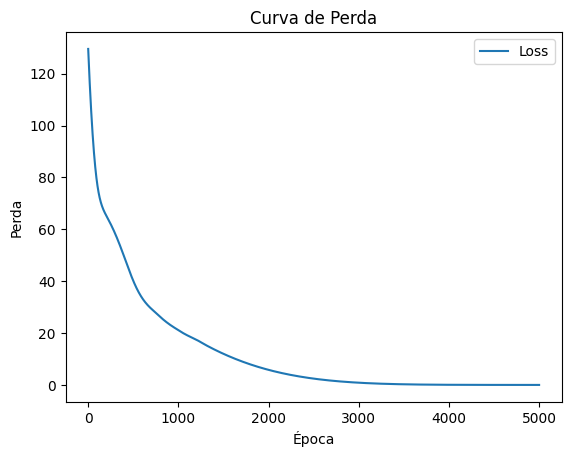

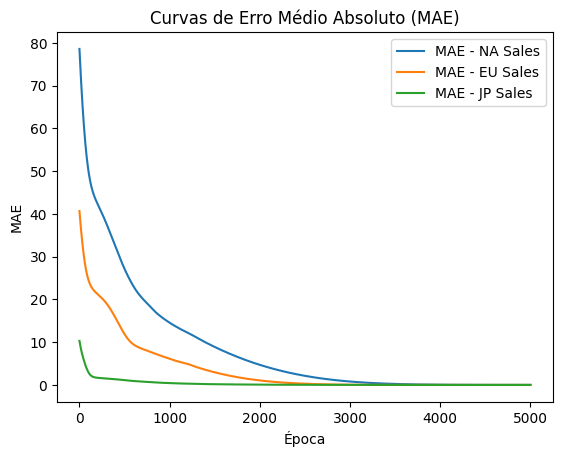

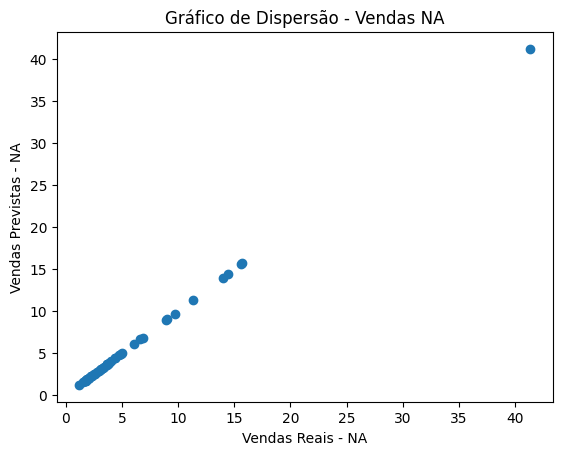

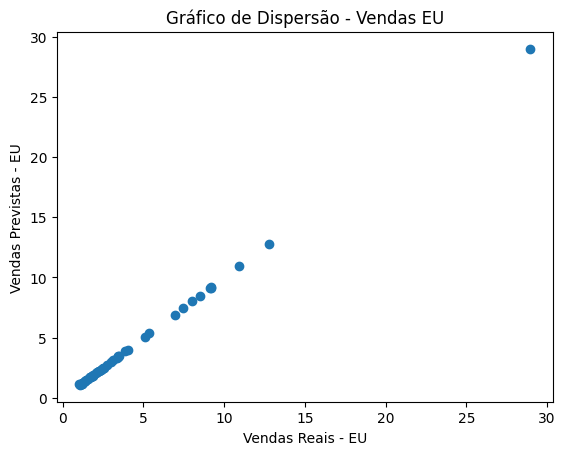

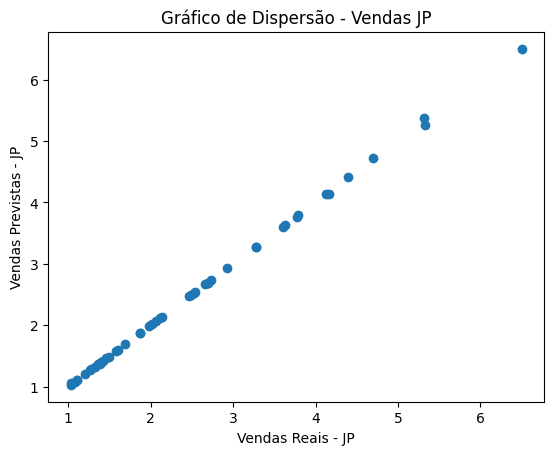

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Dense, Dropout, Activation, Input
from keras.models import Model
import matplotlib.pyplot as plt

# Carregar o conjunto de dados
base_dados = pd.read_csv('./data/Video_Games_Old.csv')

# Removendo Colunas da tabela
column_drops = ['Other_Sales','Global_Sales','Developer','Name']

data_clean = base_dados.drop(columns=column_drops)

# Imprimindo informações iniciais sobre o dataset
print("Dataset All: {} linhas | {} colunas".format(data_clean.shape[0], data_clean.shape[1]))

data_clean = data_clean.dropna(axis=0)
data_clean = data_clean.loc[data_clean['NA_Sales'] > 1]
data_clean = data_clean.loc[data_clean['EU_Sales'] > 1]
data_clean = data_clean.loc[data_clean['JP_Sales'] > 1]

previsores = data_clean.iloc[:, [0, 1, 2, 3, 7, 8, 9, 10, 11]].values
venda_na = data_clean.iloc[:, 4].values
venda_eu = data_clean.iloc[:, 5].values
venda_jp = data_clean.iloc[:, 6].values

labelencoder = LabelEncoder()
previsores[:, 0] = labelencoder.fit_transform(previsores[:, 0])
previsores[:, 2] = labelencoder.fit_transform(previsores[:, 2])
previsores[:, 3] = labelencoder.fit_transform(previsores[:, 3])
previsores[:, 8] = labelencoder.fit_transform(previsores[:, 8])


# Perform one-hot encoding on categorical features
onehotencoder = OneHotEncoder(categories='auto', sparse_output=False)
previsores = onehotencoder.fit_transform(previsores)

camada_entrada = Input(shape=(previsores.shape[1],))
camada_oculta1 = Dense(units=32, activation='sigmoid')(camada_entrada)
camada_oculta2 = Dense(units=32, activation='sigmoid')(camada_oculta1)
camada_saida1 = Dense(units=1, activation='linear')(camada_oculta2)
camada_saida2 = Dense(units=1, activation='linear')(camada_oculta2)
camada_saida3 = Dense(units=1, activation='linear')(camada_oculta2)

regressor = Model(inputs=camada_entrada, outputs=[camada_saida1, camada_saida2, camada_saida3])
regressor.compile(optimizer='adam', loss='mse')
historico = regressor.fit(previsores, [venda_na, venda_eu, venda_jp], epochs=5000, batch_size=100)

previsao_na, previsao_eu, previsao_jp = regressor.predict(previsores)


# Avaliar o desempenho do modelo
print()
print("========================================================================================")
print("Métricas de Avaliação:")
print("Erro Médio Absoluto (MAE) - NA Sales:", mean_absolute_error(venda_na, previsao_na))
print("Erro Médio Quadrático (MSE) - NA Sales:", mean_squared_error(venda_na, previsao_na))
print("Coeficiente de Determinação (R²) - NA Sales:", r2_score(venda_na, previsao_na))
print()
print("Erro Médio Absoluto (MAE) - EU Sales:", mean_absolute_error(venda_eu, previsao_eu))
print("Erro Médio Quadrático (MSE) - EU Sales:", mean_squared_error(venda_eu, previsao_eu))
print("Coeficiente de Determinação (R²) - EU Sales:", r2_score(venda_eu, previsao_eu))
print()
print("Erro Médio Absoluto (MAE) - JP Sales:", mean_absolute_error(venda_jp, previsao_jp))
print("Erro Médio Quadrático (MSE) - JP Sales:", mean_squared_error(venda_jp, previsao_jp))
print("Coeficiente de Determinação (R²) - JP Sales:", r2_score(venda_jp, previsao_jp))
print()

# Obtendo as métricas de treinamento
loss = historico.history['loss']
index = list(historico.history.keys())


mae_na = historico.history[index[1]]
mae_eu = historico.history[index[2]]
mae_jp = historico.history[index[3]]

# Plotar curva de perda
plt.plot(loss, label='Loss')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de Perda')
plt.legend()
plt.show()
print()

# Plotar curvas de erro médio absoluto
plt.plot(mae_na, label='MAE - NA Sales')
plt.plot(mae_eu, label='MAE - EU Sales')
plt.plot(mae_jp, label='MAE - JP Sales')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Curvas de Erro Médio Absoluto (MAE)')
plt.legend()
plt.show()
print()


# Plotar gráfico de dispersão NA
plt.scatter(venda_na, previsao_na)
plt.xlabel('Vendas Reais - NA')
plt.ylabel('Vendas Previstas - NA')
plt.title('Gráfico de Dispersão - Vendas NA')
plt.show()
print()

# Plotar gráfico de dispersão EU
plt.scatter(venda_eu, previsao_eu)
plt.xlabel('Vendas Reais - EU')
plt.ylabel('Vendas Previstas - EU')
plt.title('Gráfico de Dispersão - Vendas EU')
plt.show()
print()

# Plotar gráfico de dispersão JP
plt.scatter(venda_jp, previsao_jp)
plt.xlabel('Vendas Reais - JP')
plt.ylabel('Vendas Previstas - JP')
plt.title('Gráfico de Dispersão - Vendas JP')
plt.show()
print()


